In [92]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocess as mp
from IPython.display import HTML, SVG

from pydrake.geometry import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
# from pydrake.solvers.gurobi import GurobiSolver
from pydrake.solvers.mosek import MosekSolver
# from pydrake.solvers import MathematicalProgram
from pydrake.solvers.snopt import SnoptSolver
from pydrake.systems.framework import DiagramBuilder
# from pydrake.planning.common_robotics_utilities import SimpleRRTPlannerState


from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
from reproduction.prm_comparison.planning import PRM, BiRRT
from reproduction.prm_comparison.helpers import (
    ForwardKinematics,
    get_traj_length,
    InverseKinematics,
    is_traj_confined,
    make_traj,
    visualize_trajectory,
)
from reproduction.util import *

# GurobiSolver.AcquireLicense()
os.environ['MOSEKLM_LICENSE_FILE'] = '/Users/varun/mosek/mosek.lic'
MosekSolver.AcquireLicense()

print(MosekSolver().available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [93]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7004


In [94]:
SEED = 17
np.random.seed(SEED)

In [95]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_spheres_collision_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, binR, binL, table] =  models
 

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
# meshcat_params.role = Role.kProximity
meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
#plant_context = plant.GetMyContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.Publish(context)

/var/folders/p0/l4__0wtd3j184sv9zspd0qlm0000gn/T/ipykernel_8862/1353813250.py:18: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)


# Generate Iris Regions
### via manual seeds

In [96]:
milestones =  {"Above Shelve": [[0.75, 0, 0.9],    [0, -np.pi, -np.pi/2]],   
#                 "Top Rack":    [[0.75, 0, 0.67],   [0, -np.pi, -np.pi/2]],   
#                 "Middle Rack": [[0.75, 0, 0.41],   [0, -np.pi, -np.pi/2]],       
                "Left Bin":    [[0.0,  0.6, 0.22], [np.pi/2, np.pi, 0]], 
                "Right Bin":   [[0.0, -0.6, 0.22], [np.pi/2, np.pi, np.pi]],
                "Test Seed":   [[0.75, 0, 0.85],   [0, -np.pi, -np.pi/2]]}


additional_seed_points = {"Front to Shelve":np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi/2]), 
                          "Left to Shelve": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi/2]),
                          "Right to Shelve":np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi/2])} 

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in milestones.items()}

seed_points = {**milestone_configurations, **additional_seed_points}

In [97]:
print(seed_points)

{'Above Shelve': array([ 6.41950821e-05,  4.71953264e-01, -1.49318242e-04, -6.71673454e-01,
        1.85368193e-04,  4.26169599e-01,  1.57069215e+00]), 'Left Bin': array([ 1.33266562,  0.78659315,  0.36233843, -1.49165291, -0.31925088,
        0.92173247,  1.79119041]), 'Right Bin': array([-1.33246236,  0.78664776, -0.36265619, -1.49165281,  0.31953404,
        0.92178332,  1.350209  ]), 'Test Seed': array([ 9.83600730e-05,  4.14759451e-01, -1.78732762e-04, -8.88337408e-01,
        2.63138161e-04,  2.68699468e-01,  1.57061296e+00]), 'Front to Shelve': array([ 0.        ,  0.2       ,  0.        , -2.09      ,  0.        ,
       -0.3       ,  1.57079633]), 'Left to Shelve': array([ 0.8       ,  0.7       ,  0.        , -1.6       ,  0.        ,
        0.        ,  1.57079633]), 'Right to Shelve': array([-0.8       ,  0.7       ,  0.        , -1.6       ,  0.        ,
        0.        ,  1.57079633])}


In [98]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.01
iris_options.enable_ibex = False
CORE_CNT = mp.cpu_count() # you may edit this

In [99]:
def calcRegion(seed, verbose):
    print("Seed:", seed)
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly

In [100]:
def generateRegions(seed_points, verbose = True):
    seeds = list(seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
#     with mp.Pool(processes = CORE_CNT) as pool:
#         regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])
    regions = [calcRegion(seed, verbose) for seed in seeds]

    
    if verbose:
        print("Loop time:", time.time() - loop_time)
    
    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))
    
    return regions

In [101]:
regions = generateRegions(seed_points)

Seed: [ 6.41950821e-05  4.71953264e-01 -1.49318242e-04 -6.71673454e-01
  1.85368193e-04  4.26169599e-01  1.57069215e+00]
Seed: [ 6.41950821e-05  4.71953264e-01 -1.49318242e-04 -6.71673454e-01
  1.85368193e-04  4.26169599e-01  1.57069215e+00] 	Time: 71.27115797996521
Seed: [ 1.33266562  0.78659315  0.36233843 -1.49165291 -0.31925088  0.92173247
  1.79119041]
Seed: [ 1.33266562  0.78659315  0.36233843 -1.49165291 -0.31925088  0.92173247
  1.79119041] 	Time: 13.497537612915039
Seed: [-1.33246236  0.78664776 -0.36265619 -1.49165281  0.31953404  0.92178332
  1.350209  ]
Seed: [-1.33246236  0.78664776 -0.36265619 -1.49165281  0.31953404  0.92178332
  1.350209  ] 	Time: 22.78764796257019
Seed: [ 9.83600730e-05  4.14759451e-01 -1.78732762e-04 -8.88337408e-01
  2.63138161e-04  2.68699468e-01  1.57061296e+00]
Seed: [ 9.83600730e-05  4.14759451e-01 -1.78732762e-04 -8.88337408e-01
  2.63138161e-04  2.68699468e-01  1.57061296e+00] 	Time: 56.22369384765625
Seed: [ 0.          0.2         0.         

In [102]:
print(regions)

{'Above Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x14cf6e870>, 'Left Bin': <pydrake.geometry.optimization.HPolyhedron object at 0x14c3a4530>, 'Right Bin': <pydrake.geometry.optimization.HPolyhedron object at 0x14c3a45b0>, 'Test Seed': <pydrake.geometry.optimization.HPolyhedron object at 0x14c472130>, 'Front to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x10d3d2870>, 'Left to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x14c9d10b0>, 'Right to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x14d003670>}


## via pre-generated regions

In [103]:
#load regions
# with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
#     regions = pickle.load(f)

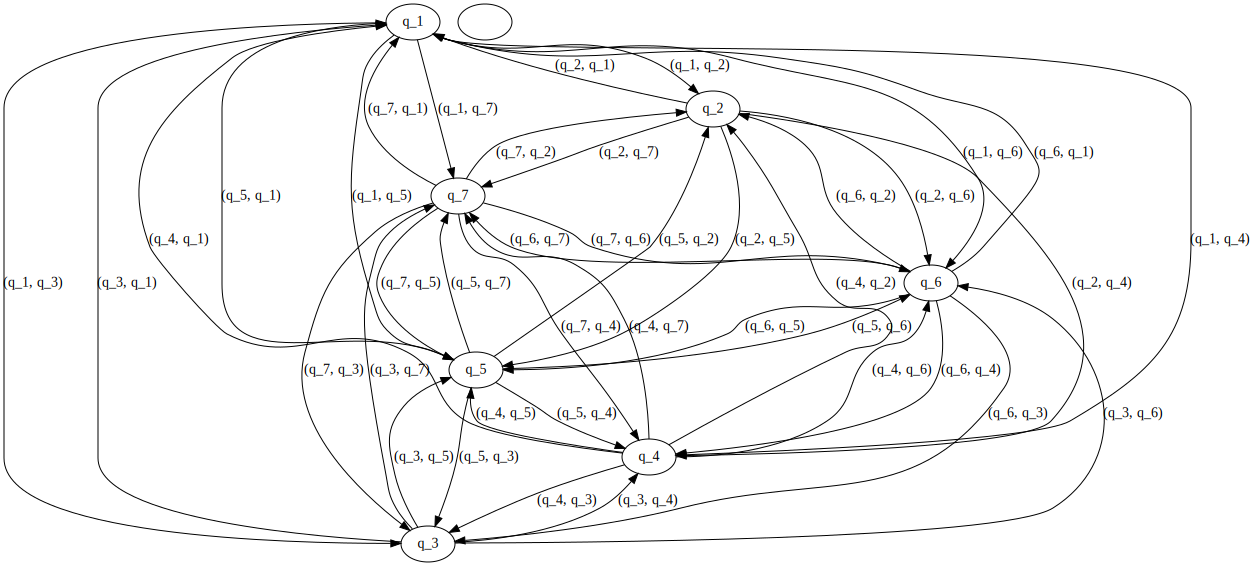

In [104]:
gcs = LinearGCS({f"q_{i + 1}":r for i, r in enumerate(regions.values())})
# print('regions', regions)
SVG(gcs.VisualizeGraph()) 

In [105]:
print(len(gcs.gcs.Edges()))
# print({f"q_{i + 1}":r for i, r in enumerate(regions.values())})

40


# Build PRM

### Load Roadmap if you don't want to wait 15 minutes

### Or Grow it 

### Connect via BiRRT first
Given the knowledge of the Graph of Convex Sets, we will use BiRRT to connect the edges. All of the nodes of the RRT trees will be added to the PRM map

### Continue growing the Roadmap

# Run Comparison

In [106]:
def getGCSPath(sequence, verbose = False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions.copy())
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
        gcs.setSolver(MosekSolver())
        start_time = time.time()
        waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["preprocessing_stats"]["linear_programs"]
        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict["total_rounded_solver_time"]
        if verbose:
            print("Convex Relaxation", round(results_dict["relaxation_cost"], 3),
                  "min hard result cost", round(results_dict["rounded_cost"], 3),
                  "Gap", round((results_dict["rounded_cost"] - results_dict["relaxation_cost"])/results_dict["relaxation_cost"], 3))
    
        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

def shortcut(path):
    """Those values are used by TRI"""
    return prm.shortcut(np.stack(path),
                 max_iter = 200,
                 max_failed_iter = 200,
                 max_backtracking_steps = 0,
                 max_shortcut_fraction = 1.0,
                 resample_shortcuts_interval = 0.25,
                 check_for_marginal_shortcuts = False)

# Demonstration

In [107]:
demonstration =  {"Above Shelve": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi/2]],   
                "Top Rack":       [[0.75, 0.12, 0.67], [0, -np.pi, -np.pi/2]],   
                "Middle Rack":    [[0.75, 0.12, 0.41], [0, -np.pi, -np.pi/2]],       
                "Left Bin":       [[0.08, 0.6, 0.22],  [np.pi/2, np.pi, 0]], 
                "Right Bin":      [[-0.08, -0.6, 0.22], [np.pi/2, np.pi, np.pi]]}

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}


In [108]:
demo_a = [demonstration_configurations["Above Shelve"],
          demonstration_configurations["Top Rack"]]

demo_b = [demonstration_configurations["Top Rack"],
          demonstration_configurations["Middle Rack"]]

demo_c = [demonstration_configurations["Middle Rack"],
          demonstration_configurations["Left Bin"]]

demo_d = [demonstration_configurations["Left Bin"],
          demonstration_configurations["Right Bin"]]

demo_e = [demonstration_configurations["Right Bin"],
          demonstration_configurations["Above Shelve"]]

demo_f = [demonstration_configurations["Above Shelve"],
         seed_points["Left to Shelve"]]


demo_circle = [demonstration_configurations["Above Shelve"],
               demonstration_configurations["Top Rack"],
               demonstration_configurations["Middle Rack"],
               demonstration_configurations["Left Bin"],
               demonstration_configurations["Right Bin"],
               demonstration_configurations["Above Shelve"]]
# print(demo_circle)
# # CHANGED FOR TESTING:
# demo_d = [milestone_configurations["Left Bin"],
#           milestone_configurations["Right Bin"]]
# print(demo_circle)

In [110]:
execute_demo = demo_d
GCS_path, GCS_time = getGCSPath(execute_demo, verbose = True)
linear_gcs_traj = make_traj(GCS_path, speed = 2)
print(f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s")

# PRM_path, PRM_time = prm.getPath(execute_demo, verbose = True)
# prm_traj = make_traj(PRM_path, speed = 2)
# print(f"PRM length: {round(get_traj_length(prm_traj), 3)}, and time: {round(PRM_time, 3)} s")

# sPRM_path, sPRM_time = prm.getPath(execute_demo, path_processing = shortcut)
# sprm_traj = make_traj(sPRM_path, speed = 2)
# print(f"Smoothed PRM length: {round(get_traj_length(sprm_traj), 3)}, and time: {round(sPRM_time, 3)} s")


edges [[1], [2]]
Convex Relaxation 3.097 min hard result cost 3.151 Gap 0.017
Linear GCS length: 3.151, and time: 0.455 s


In [ ]:
# prm.save(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

In [ ]:
# is_traj_confined(sprm_traj, regions)

In [112]:
visualize_trajectory(meshcat,
                     [linear_gcs_traj],
                     show_line = True,
                     iiwa_ghosts = execute_demo,
                     alpha =  0.3,
                     regions = [])


/Users/varun/gcs/reproduction/prm_comparison/helpers.py:233: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)


In [ ]:
# with open ("GCS_PRM15k_comparison.html", "w") as f:
#     f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [ ]:
# demos_for_paper = [demo_a, demo_b, demo_c, demo_d, demo_e]

# proposed_planner_data = []
# PRM_data = []
# sPRM_data = []

# N = 10 # We ran this 100 in the paper 
# for _ in range(N):
#     #extract trajectory and time 
#     trajectories = map(lambda d:[getGCSPath(d),prm.getPath(d),prm.getPath(d, path_processing = shortcut)], demos_for_paper)
#     #get length of trajectory
#     length_time_list = map(lambda traj_time: [[get_traj_length(make_traj(trj)), t] for trj, t in traj_time], trajectories)
#     #flatten for pandas
#     length_time_list = np.array(list(length_time_list))
    
#     proposed_planner_data.append(length_time_list[:,0].flatten())
#     PRM_data.append(length_time_list[:,1].flatten())
#     sPRM_data.append(length_time_list[:,2].flatten())
    
# proposed_planner_data = np.mean(proposed_planner_data, axis = 0)
# PRM_data = np.mean(PRM_data, axis = 0)
# sPRM_data = np.mean(sPRM_data, axis = 0)

In [ ]:
# cols = {"Proposed Planner":proposed_planner_data,
#         "Regular PRM":PRM_data,
#         "Shortcut PRM":sPRM_data}

# index = pd.MultiIndex.from_tuples([('q1-q2', 'length (rad)'), ('q1-q2', 'runtime (s)'),
#                                     ('q2-q3', 'length (rad)'), ('q2-q3', 'runtime (s)'),
#                                     ('q3-q4', 'length (rad)'), ('q3-q4', 'runtime (s)'),
#                                     ('q4-q5', 'length (rad)'), ('q4-q5', 'runtime (s)'),
#                                     ('q5-q1', 'length (rad)'), ('q5-q1', 'runtime (s)'),], names=["Task", ""])
# df = pd.DataFrame(data = cols, index=index)

In [ ]:
# df.round(2)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [ ]:
# for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
#     print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)